In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pymust
import numpy as np

In [2]:
def rgb2gray(rgb): # Convert RGB image to grayscale
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [3]:
# Get the transducer parameters
param = pymust.getparam("P4-2V")
param.attenuation = 0.5
param.RXdelay = np.zeros((1,param.Nelements), dtype = np.float32)
options = pymust.utils.Options()
options.FrequencyStep = 1/4 # Make more frequency bins, as in simus

xf = 0
zf = 4e-2
txdel= pymust.txdelay(xf, zf, param)

In [4]:
# Load the image and generate scatterers
np.random.seed(0) # For reproducibility
I = rgb2gray(mpimg.imread('data/heart.jpg')) 
# Pseudorandom distribution of scatterers
xs,_,zs,RC = pymust.genscat(np.array([np.nan, 9e-2]),1540/param.fc,I)
original_x_range = np.array([xs.min(), xs.max()])
original_z_range = np.array([zs.min(), zs.max()])

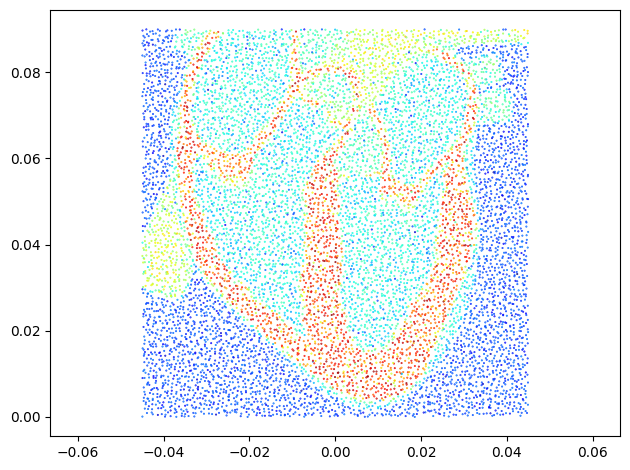

In [5]:
plt.scatter(xs, zs,  s = .2, c = np.abs(RC) **0.25, cmap ='jet')
plt.axis('equal')
plt.tight_layout()

plt.show()

In [6]:
# Set the bounds of the simulation
xbound = np.array([-2e-2,2e-2])
zbound = np.array([0,7e-2])

# P1, SPECT_P1, IDX, f = pfield_harmonic(xbound, zbound, txdel, param, lowResources=True)
P1, SPECT_P1, IDX , f = pymust.harmonic.pfield(xbound, zbound, txdel, param, options=options, lowResources=False)

P_SPECT1_full = np.zeros((SPECT_P1.shape[0], SPECT_P1.shape[1], IDX.shape[0]), dtype = SPECT_P1.dtype)
P_SPECT1_full[:, :, IDX] = SPECT_P1
del P1, SPECT_P1, IDX

DEBUG - Number of grid points in x: 233
DEBUG - of grid points in z: 403


In [7]:
# Create the range for the grid
x_range = np.linspace(param.xbound[0], param.xbound[1], param.Nx)
z_range = np.linspace(param.zbound[0], param.zbound[1], param.Nz)
x, z = np.meshgrid(x_range, z_range)

Number of scatterers (prunned):  3488


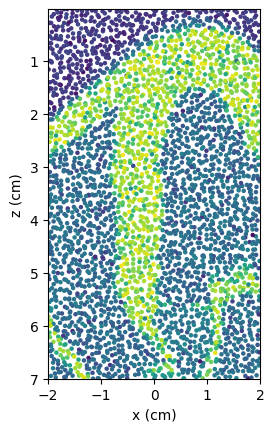

In [8]:
# Delete those scatters out of the simulated region
selected = np.logical_and(xs >= x.min(), xs <= x.max())
selected = np.logical_and(selected, zs <= z.max())
selected = np.logical_and(selected, zs >= z.min())

xs = xs[selected]
zs = zs[selected]
RC = RC[selected]
print('Number of scatterers (prunned): ', len(xs))
plt.scatter(xs*1e2, zs*1e2,  s = 5, c = np.abs(RC) **0.25)
plt.xlim(x_range[0]*1e2,x_range[-1]*1e2)
plt.ylim(z_range[-1]*1e2,z_range[0]*1e2)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.gca().set_aspect('equal')
plt.show()



In [9]:
RF_harm, RF_SPECT_harm = pymust.harmonic.simus(
    x_range=x_range,
    z_range=z_range,
    P_SPECT_grid=P_SPECT1_full,
    x_scatterers=xs,
    z_scatterers=zs,
    interpolator_name='linear_mag_nearest_phase',
    freqs=f,
    RC=RC,
    param=param,
    debug=False,
    just_RF_spectrum=False
)

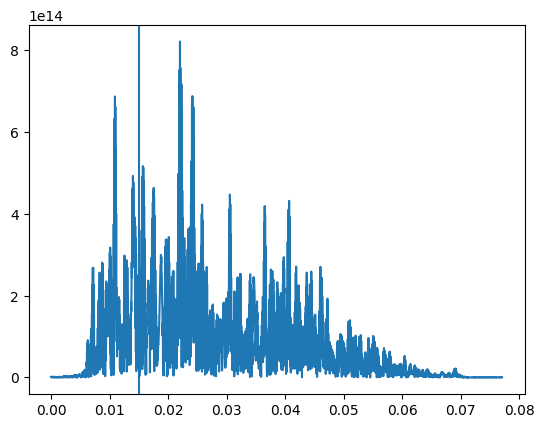

In [10]:
plt.plot(np.arange(RF_harm.shape[0])/ param.fs * param.c/2, np.abs(RF_harm[:, 32]))
plt.axvline(1.5e-2)

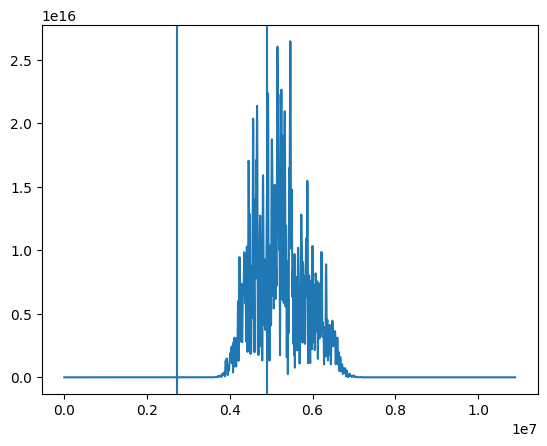

In [11]:
plt.plot(f,np.abs(RF_SPECT_harm[:, 0]))
plt.axvline(1.8*param.fc)
plt.axvline(1.*param.fc)

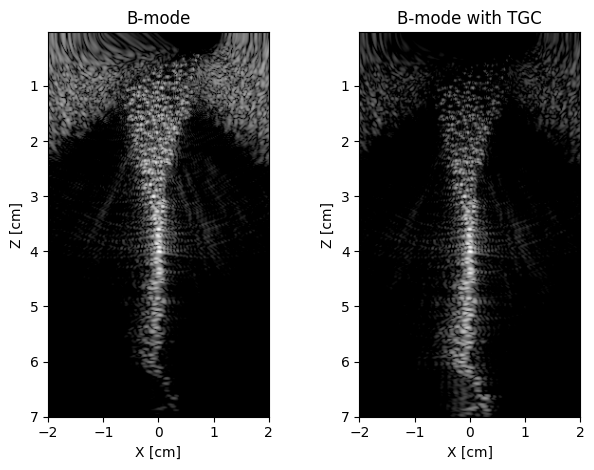

In [12]:
IQ_harm = pymust.rf2iq(RF_harm, param.fs)
IQ_tgc_harm, _ = pymust.tgc(IQ_harm)

def reconstruct(IQ, param, txdelay, xPixelGrid, zPixelGrid):
    M = pymust.dasmtx(IQ, xPixelGrid, zPixelGrid, txdelay, param)
    return pymust.utils.applyDasMTX(M, IQ, xPixelGrid.shape)

def reconstructHarmonic(IQ, param, txdelay, xPixelGrid, zPixelGrid):
    param.fc =param.fc*2
    M = pymust.dasmtx(IQ, xPixelGrid, zPixelGrid, txdelay, param)
    param.fc =param.fc/2
    return pymust.utils.applyDasMTX(M, IQ, xPixelGrid.shape)

image_rec_interp = reconstructHarmonic(IQ_harm, param, txdel, x, z)
image_rec_tgc_interp = reconstructHarmonic(IQ_tgc_harm, param, txdel, x, z)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(pymust.bmode(image_rec_interp), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.title('B-mode')
plt.gca().set_aspect('equal')
plt.subplot(1, 2, 2)
plt.imshow(pymust.bmode(image_rec_tgc_interp), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.title('B-mode with TGC')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [13]:
param2 = param.copy()
RF, RF_SPECT = pymust.simus(xs, None, zs, RC, txdel, param2)

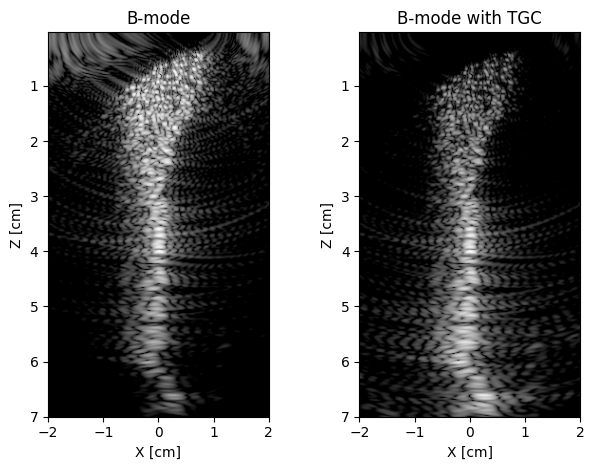

In [14]:
IQ = pymust.rf2iq(RF, param2)
IQ_tgc, _ = pymust.tgc(IQ)

image_rec = reconstruct(IQ, param2, txdel, x, z)
image_rec_tgc = reconstruct(IQ_tgc, param2, txdel, x, z)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(pymust.bmode(image_rec), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.title('B-mode')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.imshow(pymust.bmode(image_rec_tgc), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.title('B-mode with TGC')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

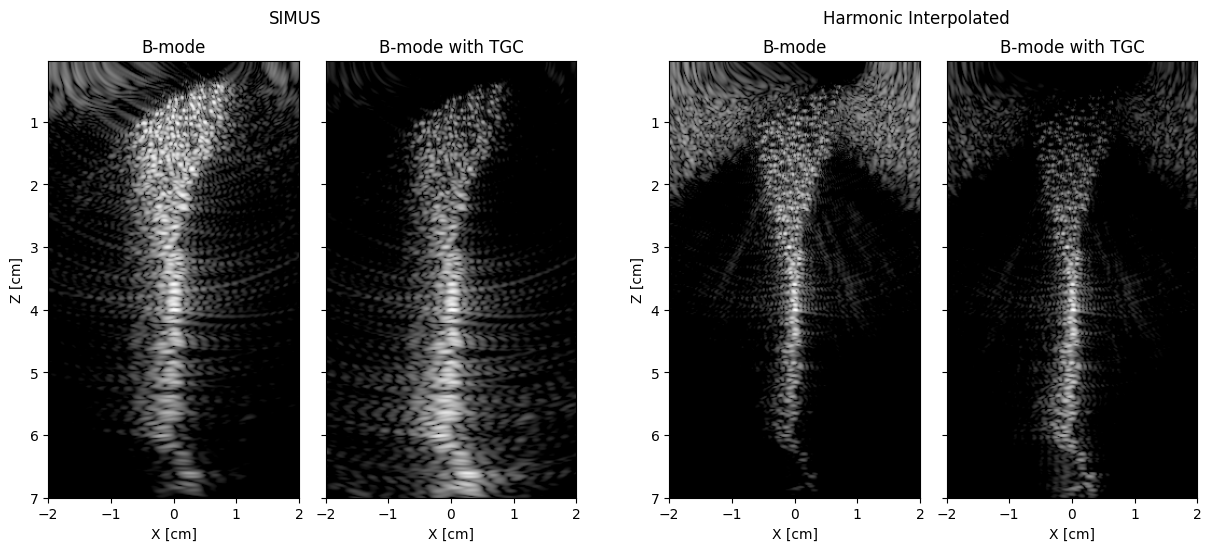

In [15]:
fig = plt.figure(layout='constrained', figsize=(12, 6))
subfigs = fig.subfigures(1, 2, wspace=0.07)
axsL = subfigs[0].subplots(1, 2, sharey=True)
subfigs[0].suptitle('SIMUS', y=0.95)
axsL[0].set_xlabel('X [cm]')
axsL[0].set_ylabel('Z [cm]')
axsL[0].set_title('B-mode')
axsL[0].imshow(pymust.bmode(image_rec), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
axsL[0].set_aspect('equal')
axsL[1].set_title('B-mode with TGC')
axsL[1].set_xlabel('X [cm]')
axsL[1].imshow(pymust.bmode(image_rec_tgc), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
axsL[1].set_aspect('equal')

subfigs[1].suptitle('Harmonic Interpolated', y=0.95)
axsR = subfigs[1].subplots(1, 2, sharey=True)
axsR[0].set_xlabel('X [cm]')
axsR[0].set_ylabel('Z [cm]')
axsR[0].set_title('B-mode')
axsR[0].imshow(pymust.bmode(image_rec_interp), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
axsR[0].set_aspect('equal')
axsR[1].set_title('B-mode with TGC')
axsR[1].set_xlabel('X [cm]')
axsR[1].imshow(pymust.bmode(image_rec_tgc_interp), cmap = 'gray', extent=[x_range[0]*1e2,x_range[-1]*1e2,z_range[-1]*1e2,z_range[0]*1e2],aspect='auto')
axsR[1].set_aspect('equal')
plt.show()